In [5]:
import cv2
import numpy as np
import dlib
from matplotlib import pyplot as plt

In [24]:
cap = cv2.VideoCapture(0)

# capture one frame and conver to gray scale
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# release the capture handle
cap.release()

In [25]:
def reset_gray(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

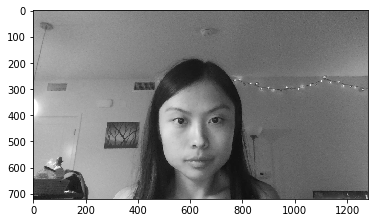

In [26]:
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

In [27]:
gray.shape

(720, 1280)

In [28]:
# front face detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../data/support/shape_predictor_68_face_landmarks.dat")
faces = detector(gray)

In [29]:
len(faces)

1

In [30]:
# for f in faces:
#     shape = predictor(gray, f)
#     for i in range(1,68): #There are 68 landmark points on each face
#         cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2)
#     plt.imshow(frame)

In [31]:
# extract the coordinates of landmarks
face1 = faces[0]

In [32]:
shape = predictor(gray, face1)
landmarks = np.asarray([(shape.part(i).x, shape.part(i).y) for i in range(68)])

In [33]:
# validate face landmark calculations
from collections import OrderedDict

In [198]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17)),
    ("inner_mouth_right_upper", (60, 63)),
])

In [35]:
# get left and right eye coordinates
(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
leftEyePts = landmarks[lStart:lEnd]
rightEyePts = landmarks[rStart:rEnd]
(leftEyePts, rightEyePts)

(array([[673, 428],
        [689, 414],
        [708, 411],
        [726, 418],
        [712, 429],
        [692, 432]]),
 array([[536, 421],
        [554, 415],
        [575, 415],
        [591, 430],
        [573, 434],
        [551, 433]]))

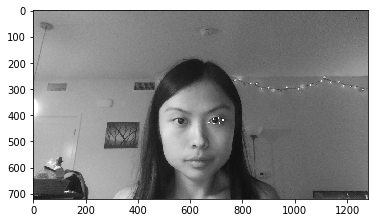

In [36]:
gray = reset_gray(frame)
for (x,y) in leftEyePts: #There are 68 landmark points on each face
    cv2.circle(gray, (x, y), 1, 255, thickness=5)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

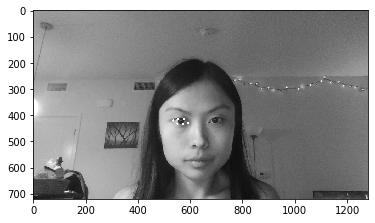

In [37]:
gray = reset_gray(frame)
for (x,y) in rightEyePts: #There are 68 landmark points on each face
    cv2.circle(gray, (x, y), 1, 255, thickness=5)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

In [38]:
# compute the center of mass for each eye
leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
(leftEyeCenter, rightEyeCenter)

(array([700, 422]), array([563, 424]))

In [39]:
# calculate the rotation angle
dY = rightEyeCenter[1] - leftEyeCenter[1]
dX = rightEyeCenter[0] - leftEyeCenter[0]
angle = np.degrees(np.arctan2(dY, dX)) - 180
(dY, dX, angle)

(2, -137, -0.8363753254224093)

In [40]:
dist1 = np.sqrt((dX ** 2) + (dY ** 2))
dist2 = np.linalg.norm(leftEyeCenter - rightEyeCenter)
dist1 == dist2

True

In [41]:
# calculate scale
desiredFaceWidth=256
desiredFaceHeight=256
desiredLeftEye=(0.35, 0.35)
dist = np.linalg.norm(leftEyeCenter - rightEyeCenter)
desiredDist = 1.0 - 2 * desiredLeftEye[0]
desiredDist *= desiredFaceWidth
scale = desiredDist / dist
scale

0.5605242160632019

In [42]:
eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2, (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
eyesCenter

(631, 423)

In [43]:
M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
M

array([[ 5.60464497e-01, -8.18196346e-03,  2.80807873e+02],
       [ 8.18196346e-03,  5.60464497e-01,  1.80760699e+02]])

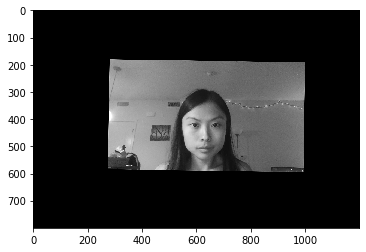

In [44]:
# use the original Affine matrix and see how we should do the translation
gray = reset_gray(frame)
output0 = cv2.warpAffine(gray, M, (1200, 800),flags=cv2.INTER_CUBIC)
plt.imshow(output0,cmap='gray', vmin=0, vmax=255)
plt.show()

In [45]:
# update the translation component of the matrix
'''
M = [A|B], where A is 2*2, and B is 2*1.
A is the rotation and scaling matrix (linear transformation),
B is the translation vector. 
Since eyesCenter's coordiantes do not change during the rotation and
scaling, we simply calculate the change of the eyescenter as the delta
for translation.
'''
tX = desiredFaceWidth * 0.5
tY = desiredFaceHeight * desiredLeftEye[1]
M[0, 2] += (tX - eyesCenter[0])
M[1, 2] += (tY - eyesCenter[1])
M

array([[ 5.60464497e-01, -8.18196346e-03, -2.22192127e+02],
       [ 8.18196346e-03,  5.60464497e-01, -1.52639301e+02]])

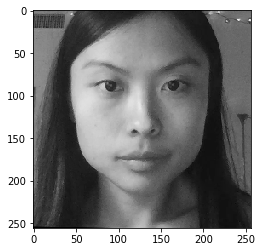

In [187]:
# apply the affine transformation
gray = reset_gray(frame)
(w, h) = (desiredFaceWidth, desiredFaceHeight)
output = cv2.warpAffine(gray, M, (w, h),flags=cv2.INTER_CUBIC)
plt.imshow(output,cmap='gray', vmin=0, vmax=255)
plt.show()

In [47]:
# calcuate the transformed cooridnates for landmarks

In [48]:
A = M[:, :2]; B = M[:, 2]
A, B

(array([[ 0.5604645 , -0.00818196],
        [ 0.00818196,  0.5604645 ]]),
 array([-222.19212699, -152.63930112]))

In [49]:
landmarks_ltfm = np.dot(A, landmarks.T)
landmarks_new = np.add(landmarks_ltfm.T, B)
landmarks_new_rounded = np.rint(landmarks_new).astype(int)

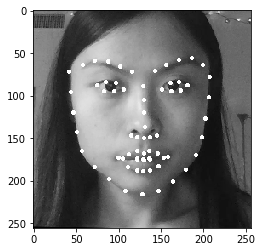

In [50]:
# circle transformed landmarks
for lm in landmarks_new_rounded: 
    cv2.circle(output, (lm[0], lm[1]), 1, (255,255,255), thickness=2)
plt.imshow(output, cmap='gray', vmin=0, vmax=255)
plt.show()

In [51]:
def convert_landmarks_to_row(landmark, label):
    row = np.append(landmark.flatten(), label)
    return row

label = 'happy'
convert_landmarks_to_row(landmarks, label)

array(['477', '394', '481', '437', '488', '479', '495', '521', '507',
       '560', '533', '593', '565', '618', '599', '642', '635', '648',
       '668', '641', '698', '620', '725', '595', '746', '564', '758',
       '527', '764', '487', '770', '443', '772', '400', '505', '380',
       '530', '369', '558', '372', '584', '382', '610', '392', '657',
       '390', '681', '376', '706', '366', '733', '362', '757', '375',
       '633', '422', '635', '450', '636', '478', '638', '507', '609',
       '526', '622', '529', '636', '531', '649', '528', '662', '525',
       '536', '421', '554', '415', '575', '415', '591', '430', '573',
       '434', '551', '433', '673', '428', '689', '414', '708', '411',
       '726', '418', '712', '429', '692', '432', '583', '573', '604',
       '565', '623', '557', '636', '562', '648', '557', '666', '563',
       '687', '569', '668', '589', '650', '599', '636', '600', '622',
       '599', '603', '591', '593', '574', '622', '574', '635', '575',
       '648', '574',

In [53]:
landmarks[:,0]

array([477, 481, 488, 495, 507, 533, 565, 599, 635, 668, 698, 725, 746,
       758, 764, 770, 772, 505, 530, 558, 584, 610, 657, 681, 706, 733,
       757, 633, 635, 636, 638, 609, 622, 636, 649, 662, 536, 554, 575,
       591, 573, 551, 673, 689, 708, 726, 712, 692, 583, 604, 623, 636,
       648, 666, 687, 668, 650, 636, 622, 603, 593, 622, 635, 648, 678,
       649, 636, 623])

In [57]:
landmarks[:,1]

array([394, 437, 479, 521, 560, 593, 618, 642, 648, 641, 620, 595, 564,
       527, 487, 443, 400, 380, 369, 372, 382, 392, 390, 376, 366, 362,
       375, 422, 450, 478, 507, 526, 529, 531, 528, 525, 421, 415, 415,
       430, 434, 433, 428, 414, 411, 418, 429, 432, 573, 565, 557, 562,
       557, 563, 569, 589, 599, 600, 599, 591, 574, 574, 575, 574, 571,
       576, 577, 576])

In [55]:
def features_by_neighbors(landmarks):
    X = landmarks[:,0]
    Y = landmarks[:,1]
    Xneighbors = zip(X[1:], X[:-1])
    Yneighbors = zip(Y[1:], Y[:-1])
    f = lambda x: x[0] - x[1]
    Xfeatures = list(map(f, Xneighbors))
    Yfeatures = list(map(f, Yneighbors))
    return np.asarray(Xfeatures + Yfeatures)

In [56]:
features_by_neighbors(landmarks)

array([   4,    7,    7,   12,   26,   32,   34,   36,   33,   30,   27,
         21,   12,    6,    6,    2, -267,   25,   28,   26,   26,   47,
         24,   25,   27,   24, -124,    2,    1,    2,  -29,   13,   14,
         13,   13, -126,   18,   21,   16,  -18,  -22,  122,   16,   19,
         18,  -14,  -20, -109,   21,   19,   13,   12,   18,   21,  -19,
        -18,  -14,  -14,  -19,  -10,   29,   13,   13,   30,  -29,  -13,
        -13,   43,   42,   42,   39,   33,   25,   24,    6,   -7,  -21,
        -25,  -31,  -37,  -40,  -44,  -43,  -20,  -11,    3,   10,   10,
         -2,  -14,  -10,   -4,   13,   47,   28,   28,   29,   19,    3,
          2,   -3,   -3, -104,   -6,    0,   15,    4,   -1,   -5,  -14,
         -3,    7,   11,    3,  141,   -8,   -8,    5,   -5,    6,    6,
         20,   10,    1,   -1,   -8,  -17,    0,    1,   -1,   -3,    5,
          1,   -1])

In [77]:
np.concatenate([np.array([1, 2]), np.array([5, 6])]).flatten()

array([1, 2, 5, 6])

In [74]:
def features_from_center(landmarks):
    '''
    Get center (mean) point (Xmean, Ymean) of all landmarks,
    substract the center point from all other landmarks.

    Return:
    features = [
        (x0 - xmean), (x1 - xmean), ..., (x67 - xmean),
        (y0 - ymean), (y1 - ymean), ..., (y67 - ymean)
    ]
    '''
    X = landmarks[:,0]
    Y = landmarks[:,1]
    Xmean = np.mean(X)
    Ymean = np.mean(Y)
    return np.concatenate([X - Xmean, Y - Ymean])

In [75]:
features_from_center(landmarks)

array([-155.52941176, -151.52941176, -144.52941176, -137.52941176,
       -125.52941176,  -99.52941176,  -67.52941176,  -33.52941176,
          2.47058824,   35.47058824,   65.47058824,   92.47058824,
        113.47058824,  125.47058824,  131.47058824,  137.47058824,
        139.47058824, -127.52941176, -102.52941176,  -74.52941176,
        -48.52941176,  -22.52941176,   24.47058824,   48.47058824,
         73.47058824,  100.47058824,  124.47058824,    0.47058824,
          2.47058824,    3.47058824,    5.47058824,  -23.52941176,
        -10.52941176,    3.47058824,   16.47058824,   29.47058824,
        -96.52941176,  -78.52941176,  -57.52941176,  -41.52941176,
        -59.52941176,  -81.52941176,   40.47058824,   56.47058824,
         75.47058824,   93.47058824,   79.47058824,   59.47058824,
        -49.52941176,  -28.52941176,   -9.52941176,    3.47058824,
         15.47058824,   33.47058824,   54.47058824,   35.47058824,
         17.47058824,    3.47058824,  -10.52941176,  -29.52941

In [87]:
import math

def angle(landmark):
    x, y = landmark
    return (math.atan2(y, x)*360)/(2*math.pi)

In [98]:
def features_from_center_with_angle(landmarks):
    '''
    Get center (mean) point (Xmean, Ymean) of all landmarks,
    calculate distance to the center point and angle

    Returns:
    features = [
        norm(landmark0 - center), angle0, norm(landmark1 - center), andle1,
        ..., norm(landmark67 - center), angle67
    ]
    '''
    center = np.mean(landmarks, axis=0)
    distances = [np.linalg.norm(l - center) for l in landmarks]
    angles = [angle(l) for l in landmarks]
    print(len(distances))
    print(len(angles))
    return np.asarray(list(zip(list(distances), list(angles))))

In [99]:
features_from_center_with_angle(landmarks_new_rounded)

68
68


array([[105.59816847,  59.74356284],
       [ 91.9611632 ,  65.37643521],
       [ 82.21547876,  68.61137717],
       [ 77.81786583,  70.37156175],
       [ 78.02697276,  70.94229549],
       [ 75.85378509,  68.62937773],
       [ 75.86813022,  65.79632348],
       [ 81.50732342,  63.00416161],
       [ 82.9707759 ,  59.34933204],
       [ 81.18299739,  55.2627069 ],
       [ 76.83310565,  50.78829282],
       [ 74.13403764,  46.25216738],
       [ 72.89458308,  41.67075647],
       [ 71.62670555,  36.9623847 ],
       [ 74.06934117,  32.15810372],
       [ 83.78141873,  26.34211153],
       [ 96.13212235,  20.64699082],
       [ 98.43676505,  47.81555668],
       [ 92.93088644,  39.33271432],
       [ 83.35132735,  34.28687698],
       [ 71.95936113,  32.90524292],
       [ 62.23227086,  31.82744658],
       [ 63.77605309,  26.40455922],
       [ 74.42585893,  22.30620505],
       [ 86.39020373,  18.73597467],
       [ 96.31765586,  16.75574893],
       [ 98.89910013,  17.82820833],
 

In [105]:
from itertools import product
ndarray1 = np.array([(0,1), (5,6), (8,9)])
ndarray2 = np.array([(0,1), (1,2), (2,3)])
list(product(ndarray1, ndarray2))

[(array([0, 1]), array([0, 1])),
 (array([0, 1]), array([1, 2])),
 (array([0, 1]), array([2, 3])),
 (array([1, 2]), array([0, 1])),
 (array([1, 2]), array([1, 2])),
 (array([1, 2]), array([2, 3])),
 (array([2, 3]), array([0, 1])),
 (array([2, 3]), array([1, 2])),
 (array([2, 3]), array([2, 3]))]

In [122]:
a = np.array([(0,1), (5,6), (8,9)])
distance_landmarks_xy(a)

([0, 5, 8, 0, 3, 0], [0, 5, 8, 0, 3, 0])

In [143]:
def distance_x(l1, l2):
    return (l2[0] - l1[0])


def distance_y(l1, l2):
    return (l2[1] - l1[1])


def distance_allpairs_xy(landmarks):
    allpairsX = []
    allpairsY = []
    for i in range(len(landmarks)):
        this = landmarks[i]
        allpairsX.extend([distance_x(this, that) for that in landmarks[i+1:]])
        allpairsY.extend([distance_y(this, that) for that in landmarks[i+1:]])
    return allpairsX, allpairsY


def distance_neighbors_xy(landmarks):
    X = landmarks[:,0]
    Y = landmarks[:,1]
    Xneighbors = zip(X[1:], X[:-1])
    Yneighbors = zip(Y[1:], Y[:-1])
    f = lambda x: x[0] - x[1]
    Xdistance = list(map(f, Xneighbors))
    Ydistance = list(map(f, Yneighbors))
    return Xdistance, Ydistance


def features_by_neighbors(landmarks):
    '''
    Substract two neighbor landmarks.

    Returns:
    features = [
        (x1 - x0), (x2 - x1), ..., (x67 - x66),
        (y1 - y0), (y2 - y1), ..., (y67 - y66)
    ]
    '''
    Xfeatures, Yfeatures = distance_neighbors_xy(landmarks)
    return np.asarray(Xfeatures + Yfeatures)


def features_by_neighbors_extended(landmarks, mouth=True):
    '''
    Get all features from the `features_by_neighbors` function plus,
    all pairs of landmarks in the mouth.
    '''
    if mouth:
        mouth_start, mounth_end = FACIAL_LANDMARKS_68_IDXS.get("mouth")
        mouth_landmarks = landmarks[mouth_start: mounth_end]
        mX, mY = distance_allpairs_xy(mouth_landmarks)
        other_landmarks = landmarks[:mouth_start]
        Xdistance, Ydistance = distance_neighbors_xy(other_landmarks)
        return np.asarray(Xdistance + mX + Ydistance + mY)
    else:
        return features_by_neighbors(landmarks)

In [145]:
features_by_neighbors_extended(landmarks)

47
[4, 7, 7, 12, 26, 32, 34, 36, 33, 30, 27, 21, 12, 6, 6, 2, -267, 25, 28, 26, 26, 47, 24, 25, 27, 24, -124, 2, 1, 2, -29, 13, 14, 13, 13, -126, 18, 21, 16, -18, -22, 122, 16, 19, 18, -14, -20] [43, 42, 42, 39, 33, 25, 24, 6, -7, -21, -25, -31, -37, -40, -44, -43, -20, -11, 3, 10, 10, -2, -14, -10, -4, 13, 47, 28, 28, 29, 19, 3, 2, -3, -3, -104, -6, 0, 15, 4, -1, -5, -14, -3, 7, 11, 3]


array([   4,    7,    7,   12,   26,   32,   34,   36,   33,   30,   27,
         21,   12,    6,    6,    2, -267,   25,   28,   26,   26,   47,
         24,   25,   27,   24, -124,    2,    1,    2,  -29,   13,   14,
         13,   13, -126,   18,   21,   16,  -18,  -22,  122,   16,   19,
         18,  -14,  -20,   21,   40,   53,   65,   83,  104,   85,   67,
         53,   39,   20,   10,   39,   52,   65,   95,   66,   53,   40,
         19,   32,   44,   62,   83,   64,   46,   32,   18,   -1,  -11,
         18,   31,   44,   74,   45,   32,   19,   13,   25,   43,   64,
         45,   27,   13,   -1,  -20,  -30,   -1,   12,   25,   55,   26,
         13,    0,   12,   30,   51,   32,   14,    0,  -14,  -33,  -43,
        -14,   -1,   12,   42,   13,    0,  -13,   18,   39,   20,    2,
        -12,  -26,  -45,  -55,  -26,  -13,    0,   30,    1,  -12,  -25,
         21,    2,  -16,  -30,  -44,  -63,  -73,  -44,  -31,  -18,   12,
        -17,  -30,  -43,  -19,  -37,  -51,  -65,  -

In [201]:
def angle_two_pts(p1, p2):
    dx, dy = p2 - p1
    return (math.atan2(dy, dx)*360)/(2*math.pi)

In [170]:
def inner_mouth_angles(landmarks):
    start, end = FACIAL_LANDMARKS_68_IDXS.get("inner_mouth")
    im_landmarks = landmarks[start: end]
    pairs = list(zip(im_landmarks[:-1], im_landmarks[1:]))
    return np.asarray([angle_two_pts(p1, p2) for (p1, p2) in pairs])

In [202]:
angle_two_pts(landmarks[0], landmarks[1])

84.68545433005525

In [172]:
inner_mouth_angles(landmarks)

60 68
[(array([593, 574]), array([622, 574])), (array([622, 574]), array([635, 575])), (array([635, 575]), array([648, 574])), (array([648, 574]), array([678, 571])), (array([678, 571]), array([649, 576])), (array([649, 576]), array([636, 577])), (array([636, 577]), array([623, 576]))]
[593 574]
[622 574]
[635 575]
[648 574]
[678 571]
[649 576]
[636 577]


array([   0.        ,    4.39870535,   -4.39870535,   -5.71059314,
        170.21759297,  175.60129465, -175.60129465])

In [199]:
def inner_mouth_angles(landmarks):
    startupper, endupper = FACIAL_LANDMARKS_68_IDXS.get("inner_mouth_right_upper")
    im_landmarks_upper = landmarks[startupper: endupper]
    pairs_upper = list(zip(im_landmarks_upper[:-1], im_landmarks_upper[1:]))
    print(pairs_upper)
    print()
    upper = [angle_two_pts(p1, p2) for (p1, p2) in pairs_upper]
    print(list(upper))
    print()
    im_landmarks_lower = [landmarks[60], landmarks[67], landmarks[66]]
    pairs_lower = list(zip(im_landmarks_lower[:-1], im_landmarks_lower[1:]))
    lower = [angle_two_pts(p1, p2) for (p1, p2) in pairs_lower]
    print(list(lower))
    return np.asarray(upper + lower)

In [203]:
inner_mouth_angles(landmarks)

[(array([593, 574]), array([622, 574])), (array([622, 574]), array([635, 575]))]

[0.0, 4.398705354995532]

[3.8140748342903548, 4.398705354995532]


array([0.        , 4.39870535, 3.81407483, 4.39870535])

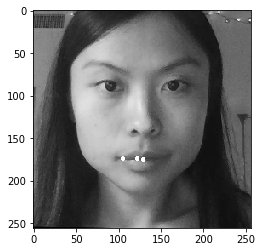

In [197]:
plt.imshow(output,cmap='gray', vmin=0, vmax=255)
cv2.circle(output, (landmarks_new_rounded[62][0], landmarks_new_rounded[62][1]), 1, (255,255,255), thickness=2)
plt.show()

In [192]:
landmarks_new_rounded

array([[ 42,  72],
       [ 44,  96],
       [ 47, 120],
       [ 51, 143],
       [ 57, 165],
       [ 72, 184],
       [ 89, 198],
       [108, 212],
       [128, 216],
       [147, 212],
       [164, 201],
       [179, 187],
       [191, 170],
       [198, 149],
       [202, 127],
       [206, 102],
       [207,  78],
       [ 58,  64],
       [ 72,  59],
       [ 88,  60],
       [102,  66],
       [116,  72],
       [143,  71],
       [156,  64],
       [171,  58],
       [186,  56],
       [199,  64],
       [129,  89],
       [130, 105],
       [130, 120],
       [131, 137],
       [115, 147],
       [122, 149],
       [130, 150],
       [137, 149],
       [145, 147],
       [ 75,  88],
       [ 85,  84],
       [ 97,  85],
       [106,  93],
       [ 95,  95],
       [ 83,  95],
       [151,  93],
       [161,  85],
       [171,  84],
       [181,  88],
       [173,  94],
       [162,  95],
       [100, 173],
       [112, 169],
       [122, 165],
       [130, 168],
       [136,